# Talktorial 11 (part A)

# Structure-based CADD using online APIs/servers

__Developed at AG Volkamer, Charité__

Dr. Jaime Rodríguez-Guerra, Dominique Sydow

## Aim of this talktorial

> This is part A of the "Online webservices" talktorial:
>
> - __11a. Querying KLIFS & PubChem for potential kinase inhibitors__
> - 11b. Docking the candidates against the target obtained in 11a
> - 11c. Assessing the results and comparing against known data

We will query the KLIFS database to obtain a kinase structure and one inhibitor. Then we will search for similar compounds in PubChem.

## Learning goals

### Theory

- Description of the pipeline and the involved webservices

### Practical

- Write the functions that will compose the pipeline
- Case study: EGFR inhibitors


## References

* KLIFS, a kinase-inhibitor interactions database.
   * Description of the database itself ([_J. Med. Chem._ (2014), __57__, 2, 249-277](https://pubs.acs.org/doi/abs/10.1021/jm400378w))
   * Description of the online service ([_Nucleic Acids Res._ (2016), __44__, 6, D365–D371](https://doi.org/10.1093/nar/gkv1082))
   * KLIFS website (http://klifs.vu-compmedchem.nl/)
* PubChem, a small compound database ([_Nucleic Acids Res._ (2019), __47__, D1102-1109](https://academic.oup.com/nar/article/47/D1/D1102/5146201))
* NGLView, the interactive visualizer for the Notebook ([_Bioinformatics_ (2018), __34__, 1241–124](https://doi.org/10.1093/bioinformatics/btx789))
* SPLIF, Structural Protein–Ligand Interaction Fingerprints([_J. Chem. Inf. Model._ (2014), __54__, 9, 2555-2561](https://pubs.acs.org/doi/abs/10.1021/ci500319f))
* PLIP: fully automated protein–ligand interaction profiler ([_Nucleic Acids Res._ (2015), __43__, W443–W447.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4489249/))
* Advances and Challenges in Computational Target Prediction ([_J. Chem. Inf. Model._ (2019), __59__, 5, 1728-1742](https://pubs.acs.org/doi/10.1021/acs.jcim.8b00832)) 
* Prediction of sensitivity to gefitinib/erlotinib for EGFR mutations in NSCLC based on structural interaction fingerprints and multilinear principal component analysis ([_BMC Bioinformatics._ (2018), __19__, 88](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5842518/))

***


## Theory

Now that you have seen how different Python libraries can be used to query online webservices, we will build a pipeline out of online webservices!

### Description of the pipeline and the involved webservices


1. Kinase-Ligand Interaction Fingerprints and Structures database (KLIFS), developed at the Division of Medicinal Chemistry - VU University Amsterdam, is a database that provides information about the protein structure (collected from the PDB) of catalytic kinase domains and the interaction with their ligands. We can obtain the curated protein structure from this database and use the ligand information to retrieve similar ligands from other databases, like PubChem or ChEMBL.
2. Using the ligand information provided by KLIFS, we can query PubChem for similar compounds.
3. After having obtained the protein structure(s) and several candidate ligands, we can dock them online with the Vina installation provided in the OPAL web services. We will also query _proteins.plus'_ DoGSiteScorer for probable binding sites where we will dock the compounds. (part B)
4. The results will be visualized with `nglview` and their interactions reported with [PLIP](https://github.com/ssalentin/plip). (part C)

In this part (A) of the talktorial, we will obtain input kinase-inhibitor structures from the _KLIFS_ database and query _PubChem_ for similar compounds that could be tested as potential inhibitors. Relevant output will be written to disk at `data/` so we can use it later on.

#### KLIFS

* Role: Kinase-ligand interaction profiles database
* Website: http://klifs.vu-compmedchem.nl/
* API: Yes, REST-based, Swagger-enabled. No official client. Use `bravado`.
* Documentation: http://klifs.vu-compmedchem.nl/swagger/
* Literature:
   * Description of the database itself ([_J. Med. Chem._ (2014), __57__, 2, 249-277](https://pubs.acs.org/doi/abs/10.1021/jm400378w))
   * Description of the online service ([_Nucleic Acids Res._ (2016), __44__, 6, D365–D371](https://doi.org/10.1093/nar/gkv1082))
    

> Kinase-Ligand Interaction Fingerprints and Structures database (KLIFS), developed at the Division of Medicinal Chemistry - VU University Amsterdam, is a database that revolves around the protein structure of catalytic kinase domains and the way kinase inhibitors can interact with them. Based on the underlying systematic and consistent protocol all (currently human and mouse) kinase structures and the binding mode of kinase ligands can be directly compared to each other. Moreover, because of the classification of an all-encompassing binding site of 85 residues it is possible to compare the interaction patterns of kinase-inhibitors to each other to, for example, identify crucial interactions determining kinase-inhibitor selectivity.

#### PubChem

* Role: Small compounds database
* Website: https://pubchem.ncbi.nlm.nih.gov/
* API: Yes, REST-based. No official client. Use `bravado`.
* Documentation: https://pubchemdocs.ncbi.nlm.nih.gov/pug-rest
* Literature:
    * [_Nucleic Acids Res._ (2019), __47__, D1102-1109](https://academic.oup.com/nar/article/47/D1/D1102/5146201)

> PubChem is an open chemistry database at the National Institutes of Health (NIH). “Open” means that you can put your scientific data in PubChem and that others may use it. Since the launch in 2004, PubChem has become a key chemical information resource for scientists, students, and the general public. Each month our website and programmatic services provide data to several million users worldwide.



<!-- michele -->
## Interaction fingerprints

As already described in Talktorial 4, fingerprints are a computational representation of molecules that encode the presence or absence of certain characteristics in compounds in the form of bit strings, bit vectors or arrays.

An Interaction Fingerprint (IFP) is a bit string of the whole binding site, which detect interaction of the ligand with every amino acid of the binding site, where a '1' stands for the presence of the interacton and a '0' for the absence. So, IFP is a method to convert three dimensional (3D) protein-ligand interactions into one dimensional (1D) bitstrings. The fingerprint makes the description of the interaction shorter and simpler and so of course the further work with it becomes easier.

<img src="images/InteractionFingerprint_2.png" align="above" alt="Image cannot be shown" width="550">
<div align="center"> Figure 1: Illustration amino acid of the binding site.</div>


### IFP methodes and intercation typs

There are different IFP methods to detected interactions and also different types of interactions between protein and ligand to observe and each tool has chosen different ones for itself.

Example methods:

- LIFt: ligand-based interaction fingerprint([_ChemMedChem. (2016), __11__, 12, 1352-61](https://www.ncbi.nlm.nih.gov/pubmed/26222196))
- SIFt: Structural interaction fingerprint([_J Med Chem. (2004), __15__, 47, 337-44](https://www.ncbi.nlm.nih.gov/pubmed/14711306))
- IFPTarget ([_J Chem Inf Model. (2017),__57__ , 1640-1651](https://www.ncbi.nlm.nih.gov/pubmed/28661143))
- SPLIF: Structural Protein–Ligand Interaction Fingerprints([_J. Chem. Inf. Model. (2014),__54__, 9 , 2555-2561](https://pubs.acs.org/doi/abs/10.1021/ci500319f))
- PADIF: protein per atom score contributions derived interaction fingerprint([_J Cheminform. (2018), __10__, 15](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5856854/)) 
- PLIFs: Protein-Ligand interaction fingerprints([_Curr Opin Drug Discov Devel. (2008), __11__, 356-64](https://www.ncbi.nlm.nih.gov/pubmed/18428089))

Example tools:

- [KLIFS](https://klifs.vu-compmedchem.nl/index.php)
- [Arpeggio](https://github.com/harryjubb/arpeggio)
- [PLIP](https://projects.biotec.tu-dresden.de/plip-web/plip)
- [PyPLIF](https://code.google.com/archive/p/pyplif/)

Example interactions:

- Hydrophobic interaction
- H-bond: protein H-bond donor, protein H-bond acceptor
- Waterbridge
- Pi-stacking: face to face aromatic, face to edge aromatic
- Pi-cation
- Saltbridge: protein cationic interaction, protein anionic interaction
- Halogen interaction
- Metal interaction

The first interaction fingerprint was called structural interaction fingerprint (SIFt). It implements seven interaction types: each contact, backbone contact, sidechain contact, polar contact, hydrophobic contact, H-bond donor and acceptor and and later expanded them by the addition of aromatic and charged interactions.

In this Talktorial a widely-applied variant, simply called Interaction Fingerprint (IFP) and used by KLIFS, is considered. Seven interactions are determined per residue. The hydrophobic contact, protein H-bond donor, protein H-bond acceptor, face to face aromatic, face to edge aromatic, protein cationic interaction, protein anionic interaction. 


<img src="images/InteractionFingerprint_1.png" align="above" alt="Image cannot be shown" width="550">
<div align="center"> Figure 2: Illustration of Interaction fingerprint per residue. Each bit of strings is assigned an interaction.</div>


### Parameter of IFP

The IFP contains several parameters that give information about the interaction.

- Interacting patterns:
    - mostly amino acid is represendted as residue
- Type of interaction:
    - hydrophobic contact, H-bond, face to edge aromatic, etc
- Direction of interaction
    - distinguish direction of interaction which means is protein or ligand donor of hydrogen bond 
- Number of bits per interaction point
    - in KLIFS are 7 bits per interaction point

### Determination IFP

Each method has its own algorithm for determining the IFP. These are the main general steps in determining IFP.

1. Protein and ligand preparation
2. Binding site identification
3. Supposedly interacting groups are compared basis of mostly geometric criteria (depending on the type of interaction, this can include distance or angle restrictions between the atomic arrangements)
4. Predefined threashold are checked to decide if an interaction takes place
5. Filtering steps are used to eliminate redundant or overlapping interactions

In this way, it is determined for each amino acid of the protein whether one of the interactions under consideration takes place. 

### Using IFP

IFPs can thus be used as a complementary method to ligand docking to quantify the similarity of predicted binding positions to a reference binding position.
In combination with docking, the superposition of ligand binding positions of a compound in multiple kinases in combination with its aligned pockets can provide insight into the next steps of ligand optimization to obtain more (or less) selective compounds.
In addition, the IFP bit sequence can be used to derive, for example, inhibitor positioning in the catalytic cleft, H-bond interaction patterns with the protein, and probing of selectivity pockets.


## KLIFS: a structural kinase-ligand interaction database

Kinase-Ligand Interaction Fingerprints and Structures Database (KLIFS) was developed by the Division of Medicinal Chemistry at VU University Amsterdam and is a database that deals with the protein structure of catalytic kinase domains and the way kinase inhibitors can interact with them. Due to the systematic and consistent protocol, all human and mouse kinase structures and the binding mode of kinase ligands can be directly compared. In addition, KLIFS offers the possibility to compare the interaction patterns of kinase inhibitors through a predefined binding site, e.g. to identify crucial interactions that determine the selectivity of kinase inhibitors.

KLIFS currently contains (11.11.2019) 4877 structures of human and mouse catalytic kinase domains from the PDB database covering 299 different kinases from all eight major kinase groups (AGC, CAMK, CK1, CMGC, STE, TK, TKL and others). The database is synchronized with the protein database through automated weekly updates.

[![KLIFS](./images/KLIFS_kinome.png)](https://klifs.vu-compmedchem.nl/index.php)
    <div align="center">Figure 1: Phylogenetic tree of the human kinome. Figure is taken from [KLIFS](https://klifs.vu-compmedchem.nl/index.php). </div>

### Data Collection, Processing and Constructing the Database

1. Collect GI numbers and mRNA RefSeq IDs for all human kinases and convert them to uniprot entries.
2. With the help of the Uniprot entries all available human protein structures are collected in the PDB.
3. A sequence similarity test is performed to select structures containing a kinase domain.
 - All sequences from human and mouse eukaryotic protein kinases are used as input to a BLAST query against all structures released by the PDB and BLAST hits (≥ 70% sequence identity and e value ≤ 0.001) are selected for preparation and further processing.
4. Structures with a kinase domain are aligned against a structural reference orientation.
 - A master sequence alignment (MSeq) of all human and mouse catalytic domains of eukaryotic protein kinases and a master-structure alignment (MStruc) comprising three structures from each kinase group were created with a focus on the binding pocket.
 - The BLAST-screened monomers are then processed with MOE by performing a sequence alignment on the MSeq.
 - The resulting sequence alignment is used to superimpose each structure on the MStruc based on the residues of the catalytic loop, the DFG motif and the hinge region.
 - Thereafter, all individual elements are extracted from water, ions, cofactors, organometals and alternative amino acids and stored in MOL2 format.
5. After extracting cofactors, ATP-containing structures, etc., the KLIFS database is created, which contains separate MOL2 files for Pocket and Ligand.

<img src="images/KLIFS_flowchart.png" align="above" alt="Image cannot be shown" width="370">
<div align="center" width="250">Figure 2: Flowchart of the KLIFS database preparation.  </div>


### Kinase Ligand Binding Sites

The analysis focuses on the catalytic cleft between the N-terminal flap and the C-terminal flap, which contains the ATP binding site and is the focus of kinase inhibitor development. This area can be divided into an anterior cleft (with the ATP binding site), a gate area and a posterior cleft. The basis of KLIFS is the definition of a consistent binding site with 85 pocket residues that interacted with each bound kinase inhibitor within the catalytic anterior column, gate region and/or posterior column.

[![KLIFS-Paper](./images/KLIFS_1.png)](https://pubs.acs.org/doi/abs/10.1021/jm400378w)
    <div align="center">Figure 3: Catalytic cleft defined by KLIFS. Figure is taken from [KLIFS-Paper](https://pubs.acs.org/doi/abs/10.1021/jm400378w). </div>
     
### Analysis of KLIFS IFP's

One of the key elements of KLIFS is the annotation of kinase-ligand-interactions by calculating IFPs with the FingerPrintLib developed by Marcou and Rognan. In KLIFS, an IFP is encoded by seven different types of interaction between each of the pocket residues (amino acid) and the ligand. The interaction types are hydrophobic contact, aromatic face-to-face, aromatic edge-to-face, H-bond donor, H-bond acceptor, ionic positive-negative and ionic negative-positive. If a structure has missing residues or gaps in the pocket, the IFP is corrected by inserting seven zeros at each position to allow systematic comparison of all IFPs within KLIFS. This procedure comments on whether a ligand does or does not address one of the 3 main pockets (front column, gate region and rear column) and the 12 sub pockets (front pockets I and II, back pockets I-A, I-B, II-in, II-A-in, II-B-in, II-out, II-B, II-B, III, IV and V). The search for specific IFP bit combinations allows the extraction of inhibitors targeting specific selectivity pockets in the kinases or forming specific hydrogen bond interactions. 

[![KLIFS-Paper](./images/KLIFS_IFP.png)](https://pubs.acs.org/doi/abs/10.1021/jm400378w)
    <div align="center">Figure 4: Comparison of four IFP's. Figure is taken from [KLIFS-paper](https://pubs.acs.org/doi/abs/10.1021/jm400378w). </div>

### Results

KLIFS provides a detailed information page with the results for each structure.

1. All information about the kinase type (names as defined by the HUGO Gene Nomenclature Committee and Uniprot, the (crystal) structure and (if present) the orthosteric and/or allosteric ligand, including a 2D chemical representation, images of the binding pocket.
2. All structural information is also displayed: DFG, ␣C-helix and G-rich loop con- formation, quality score, resolution, missing remainders and atoms. 
3. If a ligand is present in the binding site, all (sub-)pockets and all pocket waters within one of the 13 water clusters are listed. 
4. Kinase sets in ChEMBL (K i or IC 50, confidence≥8) for the bound ligand are listed.
5. The interaction profile of the ligand with the binding site is displayed, highlighting each interaction with each of the 85 binding residues.

The interaction profile of the selected structure can be used to find other kinase-ligand complexes with a similar interaction profile.

[![KLIFS](./images/KLIFS_pattern.png)](https://klifs.vu-compmedchem.nl/details.php?structure_id=9531)
    <div align="center">Figure 5: Results image of the interaction patterns from KLIFS to EGFR: 5X2A. Figure is taken from [KLIFS](https://klifs.vu-compmedchem.nl/details.php?structure_id=9531). </div>


### Applications of KLIFS

The insights the KLIFS database provides into the structural requirements of kinase binding may be useful for future structure-based ligand discovery and design studies. 
Examples of possible applications:
- Definition of protein ligand constraints and post-processing rules to drive virtual screening campaigns for the discovery of new kinase ligands.
- Designing new chemical groups that can interact with the kinase binding site in the same way (scaffold jump)
- Guidance on ligand optimization, e.g. where to place specific polar or hydrophobic groups in the optimization of known (or new) kinase ligand scaffolds.
- Provide new insights into kinase selectivity by linking ligand and kinase properties.
- The observed interaction patterns for each part of the catalytic cleavage and the corresponding inhibitor (sub-)structures provide clues for scaffold hopping and targeted detection of new/extra interactions.



***

## Practical

### Building the pipeline

#### Obtaining information from KLIFS

Choose a random kinase from a random family (in `mol2`) and the corresponding ligands (`SMILES`) from the KLIFS database. We will also obtain the PDB structure of the protein-ligand complex so we can calculate the binding pockets in part B.

In [3]:
from bravado.client import SwaggerClient
KLIFS_API_DEFINITIONS = "http://klifs.vu-compmedchem.nl/swagger/swagger.json"
KLIFS_CLIENT = SwaggerClient.from_url(KLIFS_API_DEFINITIONS, config={'validate_responses': False})

In [4]:
def _all_kinase_families():
    return KLIFS_CLIENT.Information.get_kinase_families().response().result

def _kinases_from_family(family, species="HUMAN"):
    return KLIFS_CLIENT.Information.get_kinase_names(kinase_family=family, species=species).response().result

def _protein_and_ligand_structure(*kinase_ids):
    structures = KLIFS_CLIENT.Structures.get_structures_list(kinase_ID=kinase_ids).response().result
    molcomplex = KLIFS_CLIENT.Structures.get_structure_get_pdb_complex(structure_ID=structures[0].structure_ID).response().result
    protein = KLIFS_CLIENT.Structures.get_structure_get_protein(structure_ID=structures[0].structure_ID).response().result
    ligands = KLIFS_CLIENT.Ligands.get_ligands_list(kinase_ID=kinase_ids).response().result
    ifp = KLIFS_CLIENT.Interactions.get_interactions_get_IFP(structure_ID=[structures[0].structure_ID]).response().result
    ifp_MatchResidues = KLIFS_CLIENT.Interactions.get_interactions_match_residues(structure_ID=structures[0].structure_ID).response().result
    print(f"Chosen KLIFS entry with PDB ID {structures[0].pdb} with chain {structures[0].chain} and alternate model {structures[0].alt}")
    return molcomplex, protein, [ligand.SMILES for ligand in ligands], ifp, ifp_MatchResidues

In [5]:
import random
import time

def random_kinase_structure():
    """
    Get a random kinase from a random family
    """
    attempts = 20
    families = _all_kinase_families()
    while attempts:  # some kinase IDs do not have a structure available
        family = random.choice(families)
        kinase = random.choice(_kinases_from_family(family))
        try:
            molcomplex, protein, ligands, ifp, ifp_MatchResidues = _protein_and_ligand_structure(kinase.kinase_ID)
        except:
            attempts -= 1
            time.sleep(1)
        else:                   
            print("Chosen", kinase.name, "kinase with ID", kinase.kinase_ID, "from family", family)
            return molcomplex, protein, ligands, ifp, ifp_MatchResidues
    print("Could not find a valid kinase. Try again!")
    return None, None, None, None, None


def kinase_structure_from_family(family):
    """
    Given a kinase family name (check `_all_kinase_families()`), retrieve a random structure.
    """
    attempts = 20
    while attempts:  # some kinase IDs cannot be found in the structure list...
        kinase = random.choice(_kinases_from_family(family))
        try:
            molcomplex, protein, ligands, ifp, ifp_MatchResidues = _protein_and_ligand_structure(kinase.kinase_ID)
        except:
            attempts -= 1
            time.sleep(1)
        else:                   
            print("Chosen", kinase.name, "kinase with ID", kinase.kinase_ID, "from family", family)
            return molcomplex, protein, ligands, ifp, ifp_MatchResidues
    print("Could not find a valid kinase. Try again!")
    return None, None, None, None, None

Let's check if this works. Let's say you want a random kinase from a random family, you can use `random_kinase_structure()` like this:

In [6]:
molcomplex, protein, ligands, ifp, ifp_MatchResidues = random_kinase_structure()

Chosen KLIFS entry with PDB ID 4kik with chain A and alternate model B
Chosen IKBKB kinase with ID 270 from family IKK


In [7]:
ligands

['O=C(OC)[C@]1(O)[C@@]2(O[C@@H](N3c4c5N2c6c(c5c7c(c4c8c3cccc8)C(=O)NC7)cccc6)C1)C']

Let's preview the protein with `nglview` and the ligands with `rdkit`. Run the cell below first if you have not installed `nglview` yet.

In [8]:
import nglview as nv
from tempfile import NamedTemporaryFile
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage #Needed to show molecules

def preview_molecule_contents(contents, ext="mol2"):
    # This is a temporary file, it will be autodeleted
    v = nv.NGLWidget()
    v.add_component(contents, ext=ext)
    return v

def preview_smiles(smiles):
    print(smiles)
    return Chem.MolFromSmiles(smiles)

def multi_preview_smiles(*smiles):
    legends = [f"{s[:30]}..." for s in smiles]  # shorten the smiles string to avoid text overlap
    molecules = [Chem.MolFromSmiles(s) for s in smiles]
    return MolsToGridImage(molecules, molsPerRow=3, subImgSize=(300, 300), maxMols=len(molecules),
                           legends=legends, useSVG=True)

_ColormakerRegistry()

In [9]:
v = preview_molecule_contents(protein)
v

NGLWidget()

In [10]:
v.render_image(),

(Image(value=b'', width='99%'),)

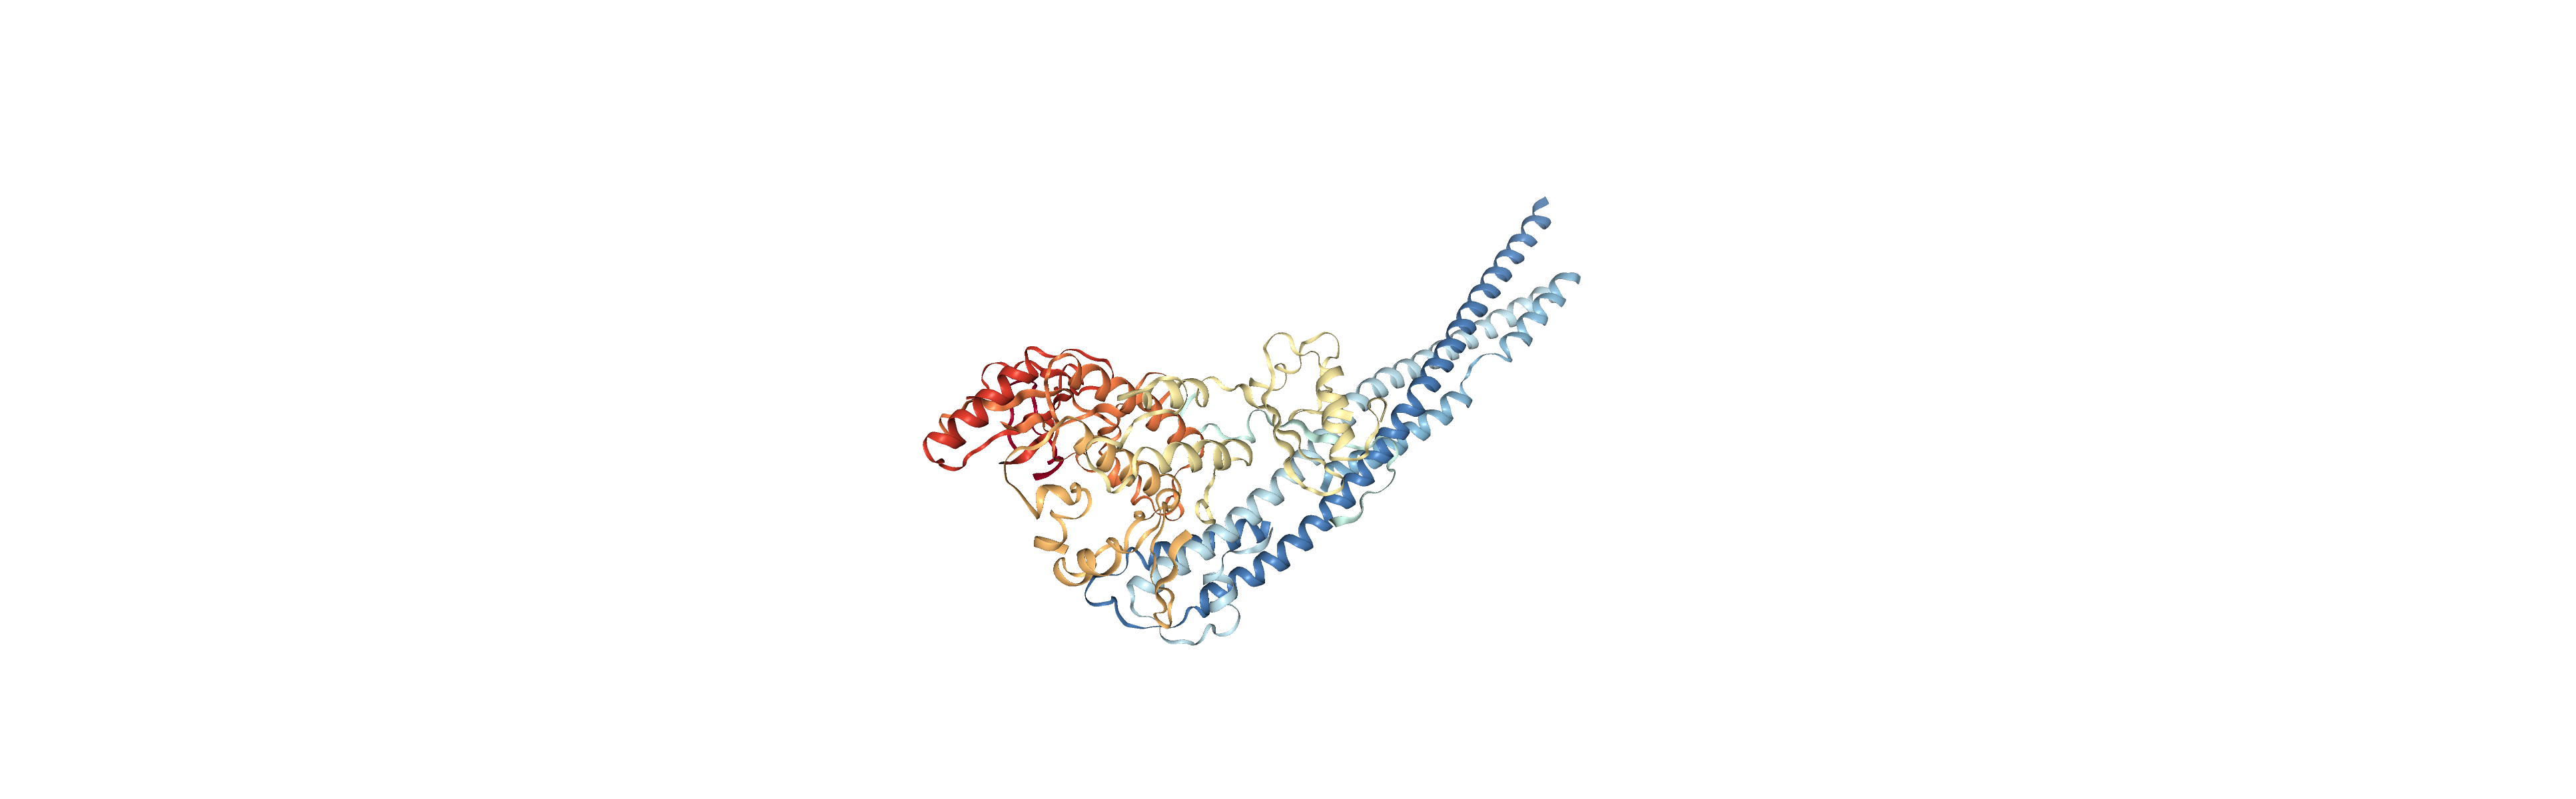

In [11]:
v._display_image()

O=C(OC)[C@]1(O)[C@@]2(O[C@@H](N3c4c5N2c6c(c5c7c(c4c8c3cccc8)C(=O)NC7)cccc6)C1)C


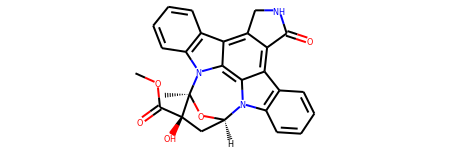

In [12]:
preview_smiles(ligands[0])

#### Query PubChem

Use the previously obtained `SMILES` string to query similar compounds in PubChem.

> Tip: You can check [Talktorial T1](https://github.com/volkamerlab/TeachOpenCADD/blob/master/talktorials/1_ChEMBL/T1_ChEMBL.ipynb) to see how to do a similar operation with ChEMBL database.

In [13]:
import requests
def similar_compounds_pubchem(smiles, threshold=75, n_records=10):
    # Query PubChem for similar compounds
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/similarity/smiles/{smiles}/JSON?Threshold={threshold}&MaxRecords={n_records}"
    r = requests.get(url)
    r.raise_for_status()
    key = r.json()['Waiting']['ListKey']
    # Response is async, poll every second for 25 seconds to see if it's done
    attempts = 25
    while attempts:
        r = requests.get(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/listkey/{key}/cids/JSON")
        r.raise_for_status()
        response = r.json()
        if 'IdentifierList' in response:
            cids = response['IdentifierList']['CID']
            break
        attempts -= 1
        time.sleep(1)
    else:
        raise IOError("Could not find matches for " + smiles)
    # We get the Compound IDs back, but we need the SMILES
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{','.join(map(str, cids))}/property/CanonicalSMILES/JSON"
    r = requests.get(url)
    r.raise_for_status()
    return [item['CanonicalSMILES'] for item in r.json()['PropertyTable']['Properties']]

In [14]:
def query_pubchem_for_similar_compounds(ligands):
    # Get the first ligand for the current kinase
    smiles = ligands[0]
    # Look for 10 most similar compounds on pubchem
    return similar_compounds_pubchem(smiles, n_records=10)

Draw the obtained compounds with RDKit

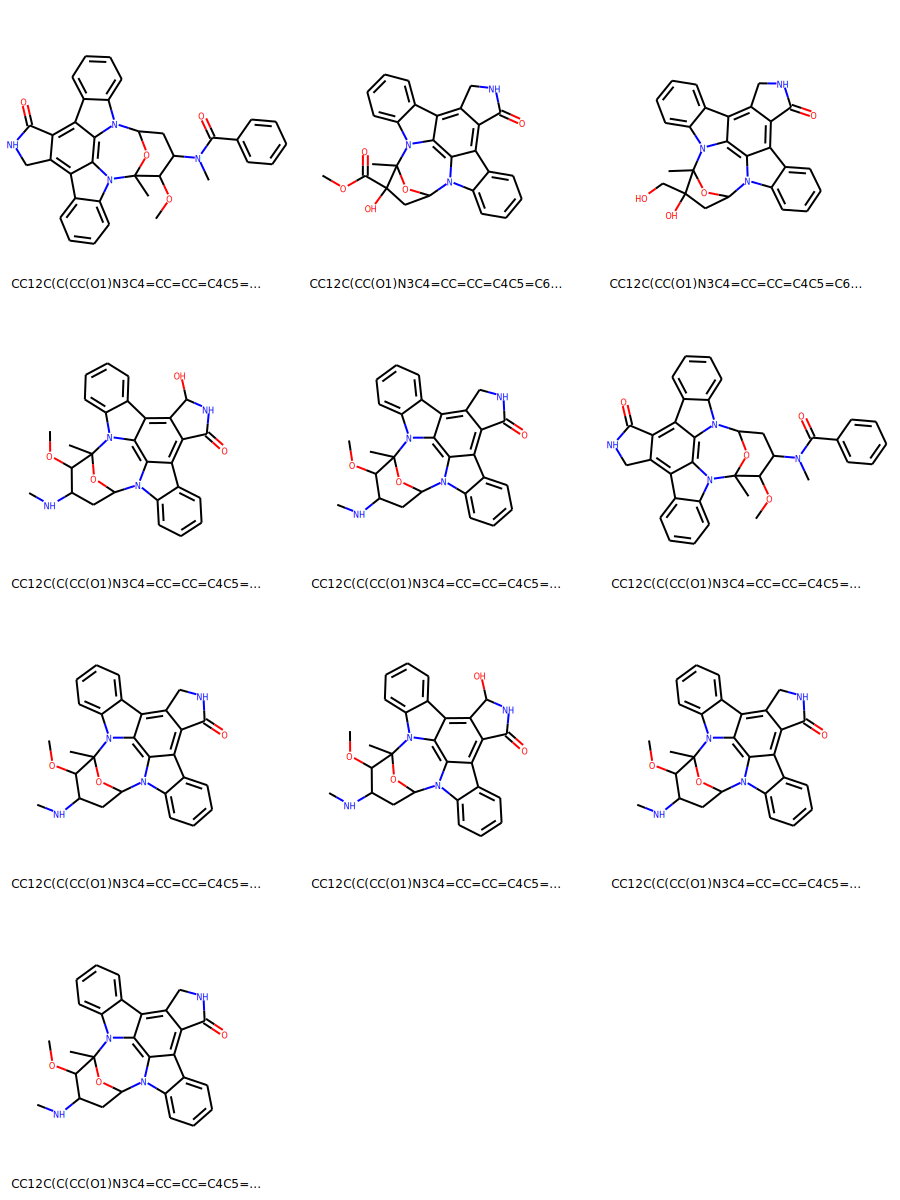

In [15]:
similar_smiles = query_pubchem_for_similar_compounds(ligands)
multi_preview_smiles(*similar_smiles)

<!-- michele -->
#### Interaction Fingerprints

Now, take a look at the interaction fingerprint of the protein. 
ifp: returns the binary code of the full IFP a specific kinase structure. This method returns a string of 85 residues x 7 interaction types = 595 bits.

In [16]:
ifp

[{'structure_ID': 288,
  'IFP': '0000000000000010000001000000100000000000000000000000000000000000000000100000000000000000000000000010000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000010000000000100110000000010000000000000000010000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000100000000000000000000100000010000000000000000000000000000000000'}]

ifp_MatchResidues: returns a list of the pocket definition of IFP

In [17]:
ifp_MatchResidues

[{'index': 1, 'Xray_position': '19', 'KLIFS_position': 'I.1'},
 {'index': 2, 'Xray_position': '20', 'KLIFS_position': 'I.2'},
 {'index': 3, 'Xray_position': '21', 'KLIFS_position': 'I.3'},
 {'index': 4, 'Xray_position': '22', 'KLIFS_position': 'g.l.4'},
 {'index': 5, 'Xray_position': '23', 'KLIFS_position': 'g.l.5'},
 {'index': 6, 'Xray_position': '27', 'KLIFS_position': 'g.l.6'},
 {'index': 7, 'Xray_position': '_', 'KLIFS_position': 'g.l.7'},
 {'index': 8, 'Xray_position': '_', 'KLIFS_position': 'g.l.8'},
 {'index': 9, 'Xray_position': '_', 'KLIFS_position': 'g.l.9'},
 {'index': 10, 'Xray_position': '28', 'KLIFS_position': 'II.10'},
 {'index': 11, 'Xray_position': '29', 'KLIFS_position': 'II.11'},
 {'index': 12, 'Xray_position': '30', 'KLIFS_position': 'II.12'},
 {'index': 13, 'Xray_position': '31', 'KLIFS_position': 'II.13'},
 {'index': 14, 'Xray_position': '41', 'KLIFS_position': 'III.14'},
 {'index': 15, 'Xray_position': '42', 'KLIFS_position': 'III.15'},
 {'index': 16, 'Xray_posit

<!-- michele -->
Create a tabel by machting binary code and residues

In [30]:
import re
import pandas as pd

# Hydrophobic: HYD
# Aromatic face-to-face: F-F
# Aromatic face-to-edge: F-E
# H-bond donor: DON
# H-bond acceptor: ACC
# Ionic positive: ION+
# Ionic negative: ION-

def get_ifp_table(ifp, ifp_MatchResidues):
    
    residues_list = []
    
    # store only residue number
    for i in ifp_MatchResidues:
        residues = i['Xray_position']
        residues_list.append(residues)
        # convert numbers to ints while keeping others (e.g. '_')
        residues_filtered = list(map(lambda x: int(x) if re.match('\d+', x) else x, residues_list))
        #residues_filtered = [k for k in residues_filtered if not k == None]
        
    # seperat IFP per residue
    n = 7
    ifps = list(ifp[0]['IFP'])
    ifps = [ifps[i:i + n] for i in range(0, len(ifps), n)]
    
    # concatenate residue and respectve IFP
    x_axis = ['HYD', 'F-F', 'F-E', 'DON', 'ACC', 'ION+', 'ION-']
    con_list = []
    
    for j in range(len(residues_filtered)):
        con = pd.DataFrame([ifps[j]], index=[residues_filtered[j]], columns=x_axis)
        con_list.append(con)
        
    con_list = pd.concat(con_list)
    con_list.index.name = 'Residue'
    
    return con_list

In [31]:
ifp_table = get_ifp_table(ifp, ifp_MatchResidues)
ifp_table

,HYD,F-F,F-E,DON,ACC,ION+,ION-
Residue,,,,,,,
343,0,0,0,0,0,0,0
344,0,0,0,0,0,0,0
345,1,0,0,0,0,0,0
346,1,0,0,0,0,0,0
347,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
481,1,0,0,0,0,0,0
482,0,0,0,0,0,0,0
483,0,0,0,0,0,0,0


### Case study: EGFR

Adapted from [the corresponding Wikipedia article](https://en.wikipedia.org/wiki/Epidermal_growth_factor_receptor):

>The epidermal growth factor receptor (EGFR) is a member of the ErbB family of receptors, a subfamily of four closely related receptor tyrosine kinases: EGFR (ErbB-1), HER2/neu (ErbB-2), Her 3 (ErbB-3) and Her 4 (ErbB-4). In many cancer types, mutations affecting EGFR expression or activity could result in cancer.
>
>Deficient signaling of the EGFR and other receptor tyrosine kinases in humans is associated with diseases such as Alzheimer's, while over-expression is associated with the development of a wide variety of tumors. Interruption of EGFR signalling, either by blocking EGFR binding sites on the extracellular domain of the receptor or by inhibiting intracellular tyrosine kinase activity, can prevent the growth of EGFR-expressing tumours and improve the patient's condition.


As a result, we are interested in finding potential inhibitors that can target members of the EGFR family. Let's repeat the same steps as above, but now targeting this specific family.

In [32]:
egfr_molcomplex, egfr_protein, egfr_ligands, egfr_ifp, egfr_ifp_MatchResidues = kinase_structure_from_family('EGFR')

Chosen KLIFS entry with PDB ID 2r4b with chain B and alternate model A
Chosen ERBB4 kinase with ID 409 from family EGFR


Preview protein:

In [33]:
v = preview_molecule_contents(egfr_protein)
v

NGLWidget()

In [34]:
v.render_image(),

(Image(value=b'', width='99%'),)

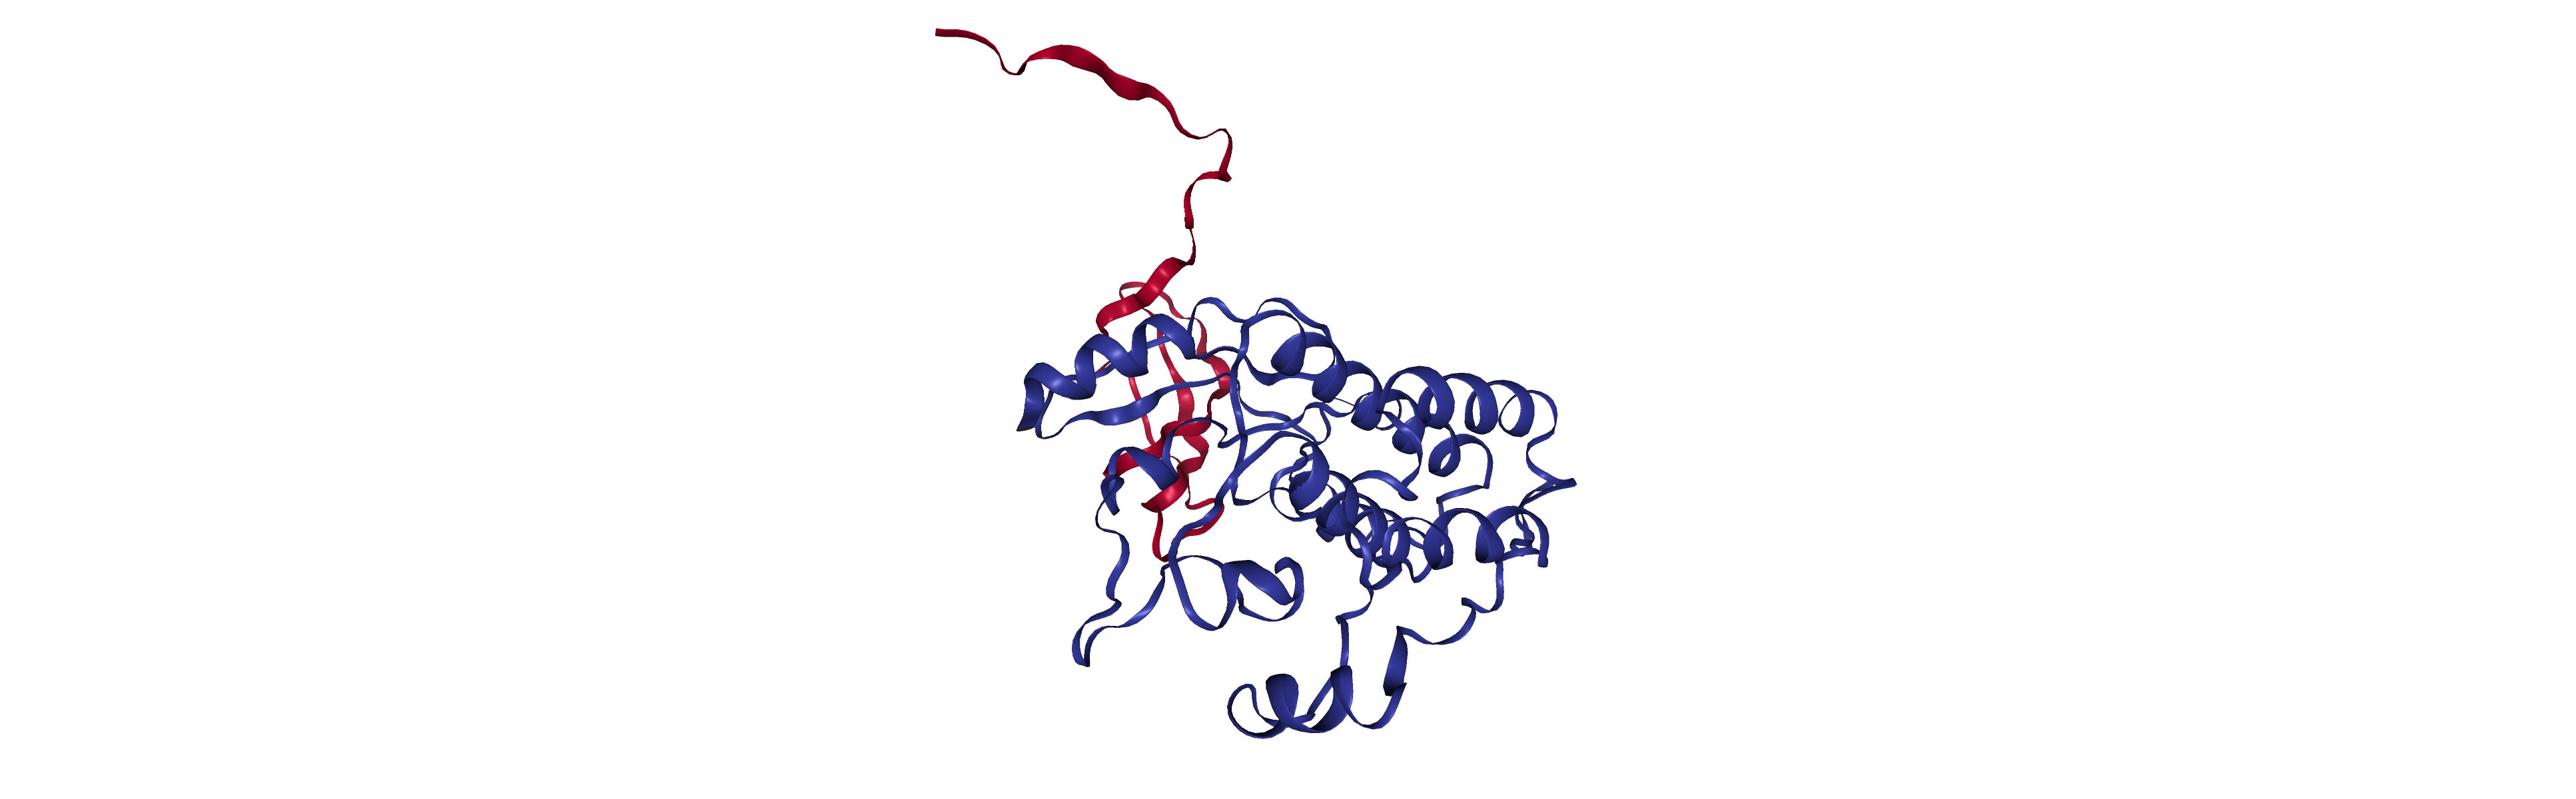

In [35]:
v._display_image()

Preview EGFR ligand (ATP):

Clc1c(OCc2cc(F)ccc2)ccc(Nc3ncnc4c3cc(cc4)C=5OC(=CC5)CNCCS(=O)(=O)C)c1


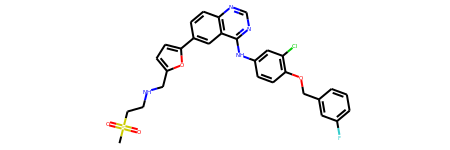

In [36]:
preview_smiles(egfr_ligands[0])

Preview similar ligands:

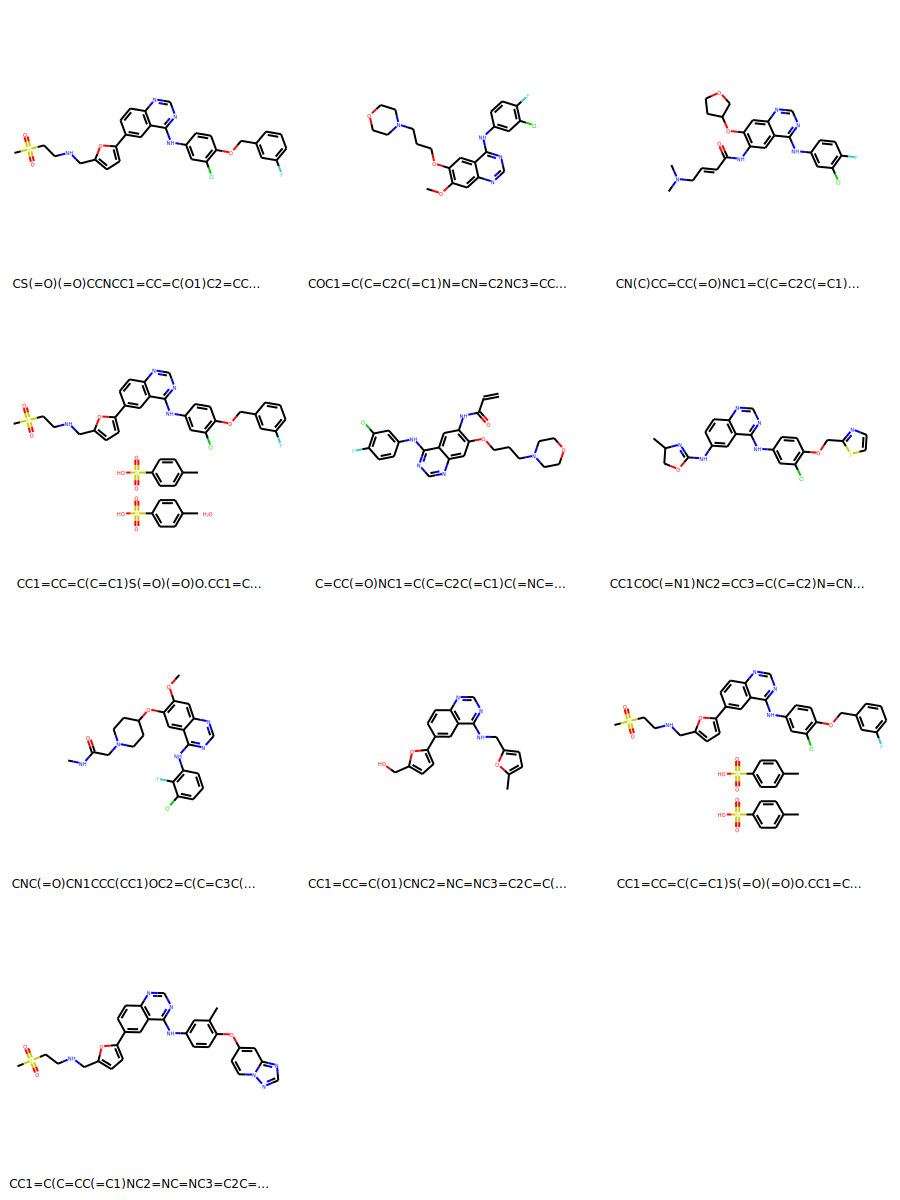

In [37]:
similar_smiles_egfr = query_pubchem_for_similar_compounds(egfr_ligands)
multi_preview_smiles(*similar_smiles_egfr)

<!-- michele -->
Generate table of EGFR-IFP

In [38]:
egfr_ifp_table = get_ifp_table(egfr_ifp, egfr_ifp_MatchResidues)
egfr_ifp_table

,HYD,F-F,F-E,DON,ACC,ION+,ION-
Residue,,,,,,,
722,0,0,0,0,0,0,0
723,0,0,0,0,0,0,0
724,1,0,0,0,0,0,0
725,0,0,0,0,0,0,0
726,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
861,1,0,0,0,0,0,0
862,1,0,1,0,0,0,0
863,0,0,0,0,0,0,0


Write results to disk for the next part of the talktorial!

In [39]:
import os
os.makedirs('data', exist_ok=True)
with open('data/similar_smiles.txt', 'w') as f:
    f.write('\n'.join(similar_smiles_egfr))
with open('data/protein.mol2', 'w') as f:
    f.write(egfr_protein)
with open('data/complex.pdb', 'w') as f:
    f.write(egfr_molcomplex)
egfr_ifp_table.to_csv("data/ifp_table.csv")

***

## Discussion

In this notebook you have learned how to access and use different web services depending on the technologies available, from well documented API to handcrafted scrapers that try to mimic an actual web browser.

So far, we have queried the KLIFS database for members of the EGFR family, obtaining a kinase structure plus (unsurprisingly) its native ligand, the ATP. Then, PubChem has provided similar compounds with more than a 75% of similarity. We will choose one of those to perform structural modeling in the next parts.


***

## Quiz

- How many kinases does KLIFS provide for the "EGFR" family?
- Can you make the similarity search more strict?
- Is any of the proposed candidates already an approved inhibitor? (Hint: You can _scrape_ [PKIDB](http://www.icoa.fr/pkidb/) and check against the list of smiles)